# Environment settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import random
from feret_utils import get_feret_files_and_tags_dict, run_face_detection, create_dataset, create_dataset_gs
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plot
from IPython.display import Image
import cv2 as cv
import tensorflow as tf
import scipy
from datetime import datetime
import pickle
tfe = tf.contrib.eager

In [2]:
# Set tf basic settings
print(tf.__version__)
tf.logging.set_verbosity(tf.logging.INFO)
tf.enable_eager_execution()

1.12.0


# Import precreated pickle file with dataset info

In [3]:
import pickle
# Unpickle data_dict holding the training and evaluation examples after performing data augmentation and regulerization
with open('feret_data_dict_gs.pickle', 'rb') as handle:
    subject_list, data_dict, mean_image, std_image = pickle.load(handle)

# Dataset sizes and examples

Shape of X_train: (6931, 96, 96, 1)
Shape of y_train: (6931,)
Shape of X_eval: (268, 96, 96, 1)
Shape of y_eval: (268,)
Example pictures of sbject ID: 0


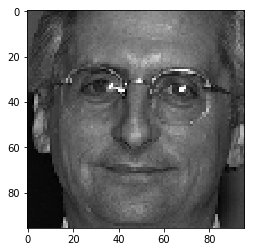

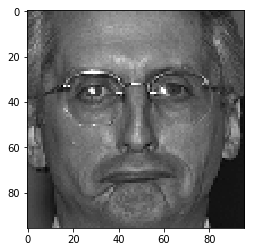

Example pictures of sbject ID: 2


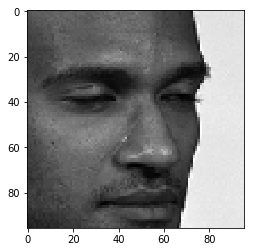

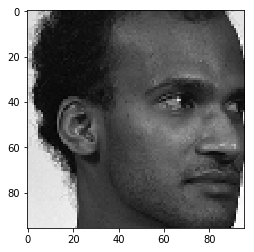

Example pictures of sbject ID: 38


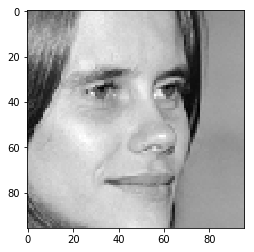

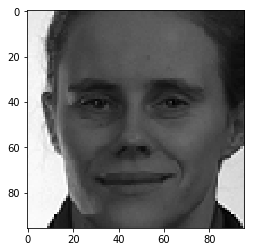

In [4]:
# Show the sizes of the datasets and a few examples of the images in it
print("Shape of X_train: {}".format(data_dict['X_train'].shape))
print("Shape of y_train: {}".format(data_dict['y_train'].shape))
print("Shape of X_eval: {}".format(data_dict['X_eval'].shape))
print("Shape of y_eval: {}".format(data_dict['y_eval'].shape))

for x in [1,43,501]:
    print("Example pictures of sbject ID: {}".format(int(data_dict['y_train'][x])))
    for i in range(2):
        pic = data_dict['X_train'][x+i]
        pic = pic * std_image + mean_image
        pic = pic.reshape(96,96)
        imshow(pic, cmap='gray')
        plot.show()

# Class to manage dataset minibatch structures for comparisson test

In [4]:
# One of the main issues in training this dataset for similarity between faces is that choosing random image "couples" for
# comparison leads to most training batches having an average of ~1.5 similar "couples" out 500 pics. And even worse, in many cases all
# examples are of different "couples" which leads to an aggrssive training towards scoring big differences.
# This class ensures having a higher rate of similars by radndommly choosing near by photos within the dataset.
# Note: this can be further improved by actually choosing specific numbers of "same" and "different" but would cost more
# computetional time during runtime.
class Dataset():
    def __init__(self, X_train, y_train, batch_size=100, num_of_epochs=10):
        self.batch_size = batch_size - (batch_size % 2)
        self.num_of_epochs = num_of_epochs
        self.X_train = X_train
        self.y_train = y_train
        
        # Hold a list of training examples we have not used yet which will be modified every time an example is used
        self.unused_y = list(range(len(y_train)))
        self.steps = int((X_train.shape[0] * self.num_of_epochs) / self.batch_size)
    
    def create_mini_batch(self):
        mini_X_train = np.zeros((self.batch_size, 96, 96, 1), dtype=np.float32)
        mini_y_train = np.zeros((self.batch_size))
        
        # Verify there are enough examples left in dataset to fill minibatch, if not reset list of unused examples
        if len(self.unused_y) < self.batch_size:
            self.unused_y = list(range(len(self.y_train)))
        half_batch = int(self.batch_size/2)
        for i in range(half_batch):
            pos = random.choice(self.unused_y)
            mini_X_train[i] = self.X_train[pos]
            mini_y_train[i] = self.y_train[pos]
            pos_shift = random.choice([4, 5, random.randrange(6, len(self.unused_y), 1)])
            mini_X_train[i + half_batch] = self.X_train[(pos + 5) % len(self.unused_y)]
            mini_y_train[i + half_batch] = self.y_train[(pos + 5) % len(self.unused_y)]
            
            # Once we used an exqmple, remove it from the 
            self.unused_y.remove(pos)
        
        return mini_X_train, mini_y_train

# Classifier model working with 2 steps of training, classification and comparison. The model will then be used to extract a feature layer which will be compared with other layers.

### The 2 phases of training are comprised of the following losses:
1. Classification loss: standard softmax loss choosing out of 700 classes
2. Image comparison loss: a loss measuring the L2 distance between the feature extraction layer of 2 images and socring according to the following:

    if image_A[id] == image_B[id]:
        loss =+ L2 distance between feature layers of image_A and image_B
    else (both faces are of different people):
        loss =+ min(0, similarity_threshold - L2 distance between feature layers of image_A and image_B)
        *similarity threshold is a parameter which can be changed

In [5]:
# Create a classifier model which uses the data dict to create a 2 phase train
# A. Image classification
# B. Images comparison
class CombinedClassifier(tf.keras.Model):
    def __init__(self, num_of_ids, loss_type="Class", similarity_threshold=5, class_lr=0.5*1e-4, sim_lr=1e-3):
        super().__init__()
        self.loss_type = loss_type
        self.similarity_threshold = similarity_threshold
        self.num_of_ids = num_of_ids
        
        # Conv layer 1 + Pooling
        self.conv1a = tf.keras.layers.Conv2D(filters=32,
                                            kernel_size=[4, 4],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool1a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 2 + Pooling
        self.conv2a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool2a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Conv layer 3 + Pooling
        self.conv3a = tf.keras.layers.Conv2D(filters=16,
                                            kernel_size=[3, 3],
                                            strides=(1, 1),
                                            padding='same',
                                            activation=tf.nn.leaky_relu,
                                            use_bias=True,
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d()
                                           )
        
        self.pool3a = tf.keras.layers.MaxPool2D(pool_size=(2, 2),
                                               strides=(2, 2),
                                               padding='valid'
                                              )
        
        # Dense output layer, also used as a feature exxtrction layer
        self.fc1a = tf.keras.layers.Dense(1024, activation=None)
        self.fc1a_act = tf.keras.layers.Activation(activation=tf.nn.relu)
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        
        # Dense layer for classes
        self.fc2a = tf.keras.layers.Dense(num_of_ids)
        
        # Optimizers
        self.optimizer1 = tf.train.AdamOptimizer(learning_rate=class_lr)
        self.optimizer2 = tf.train.AdamOptimizer(learning_rate=sim_lr, beta1=0.85)
        
    def call(self, inputs, training=True, **kwargs):
        half_batch_size = int(int(inputs.shape[0]) / 2)
        batch_size = int(half_batch_size * 2)
        
        # Input Layer
        input_layer = tf.reshape(inputs, [-1, 96, 96, 1])
        
        # Network forward flow
        x1 = self.conv1a(input_layer)
        x1 = self.pool1a(x1)
        x1 = self.conv2a(x1)
        x1 = self.pool2a(x1)
        x1 = self.conv3a(x1)
        x1 = self.pool3a(x1)
        x1 = tf.reshape(x1, [x1.shape[0], -1])
        x1_id_layer = self.fc1a(x1)
        x1_id_layer_act = self.fc1a_act(x1_id_layer)
        
        # If we are training for classification loss, use dropout.
        if (training):
            if self.loss_type is "Class":
                x1_dropout = self.dropout(x1_id_layer_act)
                x1_logits = self.fc2a(x1_dropout)
            else:
                x1_logits = self.fc2a(x1_id_layer_act)
                
            # Get L2 distances between image "couples"
            distances = tf.reduce_mean((x1_id_layer[0:half_batch_size] - x1_id_layer[half_batch_size:batch_size])**2, axis=1)

        else:
            x1_logits = self.fc2a(x1_id_layer_act)
            distances = 0

        
        return x1_logits, x1_id_layer, distances 
    
    def loss(self, logits1, labels1, distances, batch_size):        
        half_batch_size = int(batch_size / 2)
        
        # Just to make sure that both halves are equal
        batch_size = int(half_batch_size * 2)
        
        # Calculate losses according to classification requirments and comparison requirement
        # Loss 1: classification requirement
        onehot_labels = tf.one_hot(indices=tf.cast(labels1, tf.int32), depth = num_of_ids)
        loss_1 = tf.losses.softmax_cross_entropy(onehot_labels, logits1)
            
        # Loss 2: comparison requirement
        same = np.where(np.array(labels1[0:half_batch_size] - labels1[half_batch_size:batch_size]) == 0)[0]
        diff = np.arange(half_batch_size)
        diff = np.delete(diff, same)
        if (len(same) > 0):
            loss_same = tf.reduce_mean((tf.gather(distances, same)))
        loss_diff = tf.reduce_mean(tf.maximum(0, self.similarity_threshold - tf.gather(distances, diff)))
        
        # Give loss_same and loss_diff the same weight for gradient update purposes
        loss_2 = loss_same + loss_diff
        
        return loss_1, loss_2
    
    def optimize(self, inputs, labels):
        with tf.GradientTape(persistent=True) as tape:
            x1_logits, x1_id_layer, distances = self(inputs)
            loss_1, loss_2 = self.loss(x1_logits, labels, distances, int(inputs.shape[0]))
        
        # Apply gradinets according totraining phase we are in
        if self.loss_type is "Class":
            gradients = tape.gradient(loss_1, self.variables)
            self.optimizer1.apply_gradients(zip(gradients, self.variables))
        if self.loss_type is "Similarity":
            # For similarity training apply gradients only to the fc1a layer
            gradients = tape.gradient(loss_2, self.variables[6:8])
            self.optimizer2.apply_gradients(zip(gradients, self.variables[6:8]))
            
        del(tape)
        return loss_1, loss_2
    
    def test(self, inputs, labels, similarity_test=False, training_set=False, debug_print=False, thresh=1):
        x1_logits, x1_id_layer, distance = self(inputs, training=False)
        test_class_1, test_class_2, test_compare = 0, 0, 0
        
        # Scores for predecting image labels
        pred_labels = tf.argmax(x1_logits, axis=-1)
        pred_labels = tf.cast(pred_labels, tf.float64)
        label_acc = tf.reduce_mean(tf.cast(tf.equal(pred_labels, labels), tf.float32))
        
        # Scores for the similarity test
        correct, incorrect = 0, 0
        similarity_acc = 0
        sum_of_distances_for_sim, sum_of_distances_for_diff, sim_count, diff_count = 0, 0, 0, 0
        sim_diff_ratio = 0
        
        size = int(inputs.shape[0]) if (int(inputs.shape[0]) % 2 == 0) else int(inputs.shape[0]) - 1
        
        if (similarity_test):
            # Training and validation set have different structures so testing method is split into 2 options
            if (training_set):
                for i in range(0, int(size/2)):
                    if int(labels[i]) == int(labels[int(size/2) + i]):
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) < thresh:
                            correct +=1
                        else:
                            incorrect +=1
                    else:
                        if (tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[int(size/2) + i])**2))) > thresh:
                            correct +=1
                        else:
                            incorrect +=1
            else:
                for i in range(0, size, 2):
                    if int(labels[i]) == int(labels[i + 1]):
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_sim += distance
                        sim_count += 1
                        if distance < thresh:
                            if(debug_print):
                                print("Got similar pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got similar pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                    else:
                        distance = tf.reduce_mean(tf.abs((x1_id_layer[i] - x1_id_layer[i + 1])**2))
                        sum_of_distances_for_diff += distance
                        diff_count += 1
                        if distance > thresh:
                            if(debug_print):
                                print("Got different pics correct: distance = {} thresh = {}".format(distance, thresh))
                            correct +=1
                        else:
                            if(debug_print):
                                print("Got different pics wrong: distance = {} thresh = {}".format(distance, thresh))
                            incorrect +=1
                            
                distance_average_sim = sum_of_distances_for_sim/sim_count
                distance_average_diff = sum_of_distances_for_diff/diff_count
                # sim_diff_ratio is the ration of differences between distances predicted for similar pairs and the 
                # distacnes predicted for different pairs. The lower the difference the better the model will differ between
                # similar and different images
                sim_diff_ratio = distance_average_sim/distance_average_diff
                            
            # similarity_acc is the percantage of correct predictions
            similarity_acc = correct/(correct + incorrect)
            
            
        return label_acc, similarity_acc, sim_diff_ratio
        


# Phase 1: Train using classification loss

In [7]:
num_of_ids = len(subject_list)
# Metrics to save
loss1_val = []
loss_step = []
acc_val = []
acc_train = []
evaluation_step = []
best_score = 0

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 20
STEP_SIZE_EVALUATE = 40

batch_size = 800
num_of_epochs = 35

dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Class", class_lr=1e-3)
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0 and step != 0):
            
            # Evaluate on validation set
            accuracy, _, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=False)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_val.append(accuracy)
            evaluation_step.append(step)
            if (accuracy > best_score):
                model.save_weights('cpt/cpt_%s' % step)
                name_save = ('cpt/cpt_%s' % step)
                bestt_score = accuracy
            
            # Evaluate on training set
            accuracy, _, _ = model.test(batch_x, batch_y, similarity_test=False)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: classification accuracy: %f" % (step, accuracy)))
            acc_train.append(accuracy)
            
        # Train
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: classification loss: %f" % (step, loss1)))
        

[29.12|17:11:42] Step 0: classification loss: 6.553853
[29.12|17:11:52] Step 20: classification loss: 4.798841
[29.12|17:12:02] EVAL SET: Step 40: classification accuracy: 0.250000
[29.12|17:12:03] TRAIN SET: Step 40: classification accuracy: 0.530000
[29.12|17:12:03] Step 40: classification loss: 2.036846
[29.12|17:12:13] Step 60: classification loss: 0.582389
[29.12|17:12:23] EVAL SET: Step 80: classification accuracy: 0.541045
[29.12|17:12:23] TRAIN SET: Step 80: classification accuracy: 0.922500
[29.12|17:12:24] Step 80: classification loss: 0.316816
[29.12|17:12:34] Step 100: classification loss: 0.094255
[29.12|17:12:44] EVAL SET: Step 120: classification accuracy: 0.641791
[29.12|17:12:44] TRAIN SET: Step 120: classification accuracy: 0.995000
[29.12|17:12:44] Step 120: classification loss: 0.037377
[29.12|17:12:54] Step 140: classification loss: 0.009298
[29.12|17:13:04] EVAL SET: Step 160: classification accuracy: 0.679105
[29.12|17:13:05] TRAIN SET: Step 160: classification a

## Classification loss

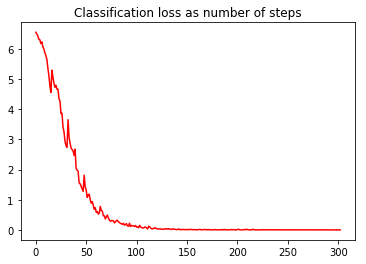

In [8]:
plot.title('Classification loss as number of steps')
plot.plot(loss_step, loss1_val, 'r')
plot.show()

## Classification accuracy

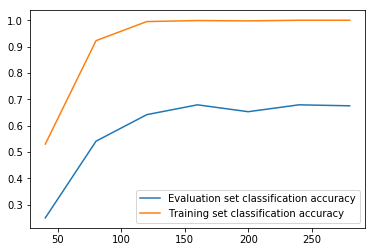

In [9]:
plot.plot(evaluation_step, acc_val, label='Evaluation set classification accuracy')
plot.plot(evaluation_step, acc_train, label='Training set classification accuracy')
plot.legend()
plot.show()

# Phase 2: train using similarity loss

In [6]:
# Function used to get the best similarty score using different thresholds, returns best score and threshold
def get_best_score(model):
    best_sim=0
    threshs = np.arange(0, model.similarity_threshold, model.similarity_threshold/200)
    for i in threshs:
        accuracy, sim, _ = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=i)
        if (sim > best_sim):
            best_sim = sim
            best_thresh = i
    return (best_sim, best_thresh)

### This phase is done with setting similarity threshold to 3 options (5, 10, 20) and comparing the results

## Training using similarity loss, similarity threshold set to 5

In [7]:
name_save='cpt/cpt_280'

In [8]:
num_of_ids = len(subject_list)

#Metrics to save
loss1_val = []
loss2_val = []
loss_step = []
sim_val = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 50
STEP_SIZE_EVALUATE = 200
best_sim = 0
best_thresh = 1

batch_size = 1000
num_of_epochs = 300
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0):          
            # Evaluate on validation set
            sim, thresh = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_5')
                best_sim = sim
                best_thresh = thresh
            
            # Evaluate on training set
            _, sim, _= model.test(batch_x, batch_y, similarity_test=True, training_set=True, thresh=best_thresh)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_train.append(sim)

            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Similartiy loss: %f" % (step, loss2)))


[29.12|17:30:58] EVAL SET: Step 0: similarity accuracy: 0.694030
[29.12|17:30:59] TRAIN SET: Step 0: similarity accuracy: 0.476000
[29.12|17:31:01] Step 0: Similartiy loss: 91.367500
[29.12|17:31:32] Step 50: Similartiy loss: 4.074768
[29.12|17:32:04] Step 100: Similartiy loss: 2.882628
[29.12|17:32:35] Step 150: Similartiy loss: 2.261980
[29.12|17:33:42] EVAL SET: Step 200: similarity accuracy: 0.813433
[29.12|17:33:44] TRAIN SET: Step 200: similarity accuracy: 0.946000
[29.12|17:33:44] Step 200: Similartiy loss: 2.058269
[29.12|17:34:15] Step 250: Similartiy loss: 1.474717
[29.12|17:34:47] Step 300: Similartiy loss: 2.134402
[29.12|17:35:18] Step 350: Similartiy loss: 2.021570
[29.12|17:36:26] EVAL SET: Step 400: similarity accuracy: 0.805970
[29.12|17:36:27] TRAIN SET: Step 400: similarity accuracy: 0.960000
[29.12|17:36:27] Step 400: Similartiy loss: 1.874071
[29.12|17:36:58] Step 450: Similartiy loss: 1.533298
[29.12|17:37:30] Step 500: Similartiy loss: 1.387851
[29.12|17:38:01] S

## Similarity Loss 

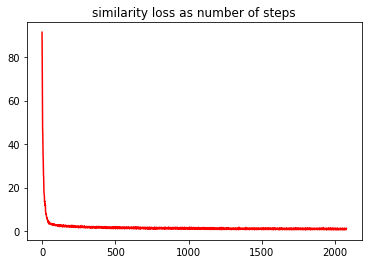

In [9]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

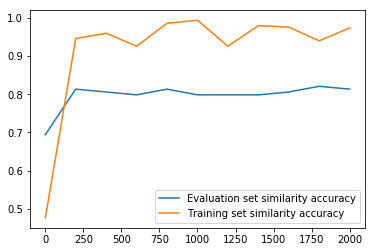

In [10]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [21]:
model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
model.load_weights('cpt/cpt_sim_5')
_, sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity threshold = 5: similarity accuracy = {}, sim diff ratio = ()".format(sim, ratio))

Summary for similarity threshold = 5: similarity accuracy = 0.8208967164179104, sim diff ratio = 0.4815664291381836


## Training using similarity loss, similarity threshold set to 10

In [13]:
num_of_ids = len(subject_list)

#Metrics to save
loss1_val = []
loss2_val = []
loss_step = []
sim_val = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 50
STEP_SIZE_EVALUATE = 200
best_sim = 0
best_thresh = 1

batch_size = 1000
num_of_epochs = 300
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=10)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0):          
            # Evaluate on validation set
            sim, thresh = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_10')
                best_sim = sim
                best_thresh = thresh
            
            # Evaluate on training set
            _, sim, _= model.test(batch_x, batch_y, similarity_test=True, training_set=True, thresh=best_thresh)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_train.append(sim)

            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Similartiy loss: %f" % (step, loss2)))


[29.12|18:07:31] EVAL SET: Step 0: similarity accuracy: 0.701493
[29.12|18:07:32] TRAIN SET: Step 0: similarity accuracy: 0.500000
[29.12|18:07:32] Step 0: Similartiy loss: 86.648102
[29.12|18:08:03] Step 50: Similartiy loss: 6.253064
[29.12|18:08:35] Step 100: Similartiy loss: 5.075067
[29.12|18:09:06] Step 150: Similartiy loss: 4.262559
[29.12|18:10:15] EVAL SET: Step 200: similarity accuracy: 0.798507
[29.12|18:10:16] TRAIN SET: Step 200: similarity accuracy: 0.950000
[29.12|18:10:16] Step 200: Similartiy loss: 3.712497
[29.12|18:10:48] Step 250: Similartiy loss: 2.900578
[29.12|18:11:19] Step 300: Similartiy loss: 4.257166
[29.12|18:11:51] Step 350: Similartiy loss: 3.822187
[29.12|18:12:58] EVAL SET: Step 400: similarity accuracy: 0.798507
[29.12|18:12:59] TRAIN SET: Step 400: similarity accuracy: 0.918000
[29.12|18:12:59] Step 400: Similartiy loss: 3.689145
[29.12|18:13:31] Step 450: Similartiy loss: 3.234328
[29.12|18:14:02] Step 500: Similartiy loss: 2.803951
[29.12|18:14:34] S

## Similarity Loss 

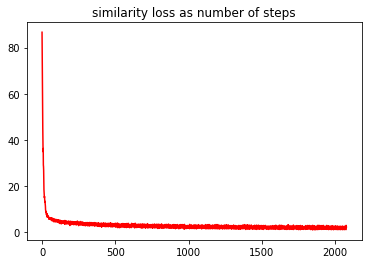

In [14]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

## Evaluation for similarity check

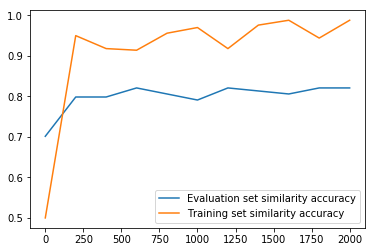

In [15]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [20]:
model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
model.load_weights('cpt/cpt_sim_10')
_, sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity threshold = 10: similarity accuracy = {}, sim diff ratio = {}".format(sim, ratio))

Summary for similarity threshold = 5: similarity accuracy = 0.8208967164179104, sim diff ratio = 0.4723349129146075


## Training using similarity loss, similarity threshold set to 20

In [22]:
num_of_ids = len(subject_list)

#Metrics to save
loss1_val = []
loss2_val = []
loss_step = []
sim_val = []
sim_train = []
evaluation_step = []

# Globals affecting logging and evaluation frequency
STEP_SIZE_LOSS = 50
STEP_SIZE_EVALUATE = 200
best_sim = 0
best_thresh = 1

batch_size = 1000
num_of_epochs = 300
dataset = Dataset(data_dict['X_train'], data_dict['y_train'], batch_size, num_of_epochs)
with tf.device("/device:GPU:0"):
    model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=20)
    model.load_weights(name_save)
    
    for step in range(dataset.steps):
        batch_x, batch_y = dataset.create_mini_batch()
        if (step % STEP_SIZE_EVALUATE == 0):          
            # Evaluate on validation set
            sim, thresh = get_best_score(model)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "EVAL SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_val.append(sim)
            evaluation_step.append(step)
            if (sim > best_sim):
                model.save_weights('cpt/cpt_sim_20')
                best_sim = sim
                best_thresh = thresh
            
            # Evaluate on training set
            _, sim, _= model.test(batch_x, batch_y, similarity_test=True, training_set=True, thresh=best_thresh)
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "TRAIN SET: Step %d: similarity accuracy: %f" % (step, sim)))
            sim_train.append(sim)

            
        
        loss1, loss2 = model.optimize(batch_x, batch_y)
        loss1_val.append(loss1)
        loss2_val.append(loss2)
        loss_step.append(step)
        
        if (step % STEP_SIZE_LOSS == 0):
            print('[{0}] {1}'.format(datetime.now().strftime('%d.%m|%H:%M:%S'),
                                     "Step %d: Similartiy loss: %f" % (step, loss2)))


[29.12|18:46:53] EVAL SET: Step 0: similarity accuracy: 0.701493
[29.12|18:46:54] TRAIN SET: Step 0: similarity accuracy: 0.514000
[29.12|18:46:55] Step 0: Similartiy loss: 88.493538
[29.12|18:47:26] Step 50: Similartiy loss: 12.050408
[29.12|18:47:58] Step 100: Similartiy loss: 10.197244
[29.12|18:48:29] Step 150: Similartiy loss: 8.876447
[29.12|18:49:37] EVAL SET: Step 200: similarity accuracy: 0.805970
[29.12|18:49:38] TRAIN SET: Step 200: similarity accuracy: 0.954000
[29.12|18:49:38] Step 200: Similartiy loss: 6.751466
[29.12|18:50:10] Step 250: Similartiy loss: 6.751713
[29.12|18:50:41] Step 300: Similartiy loss: 8.432357
[29.12|18:51:13] Step 350: Similartiy loss: 7.418748
[29.12|18:52:20] EVAL SET: Step 400: similarity accuracy: 0.798507
[29.12|18:52:21] TRAIN SET: Step 400: similarity accuracy: 0.922000
[29.12|18:52:21] Step 400: Similartiy loss: 7.262477
[29.12|18:52:53] Step 450: Similartiy loss: 6.327120
[29.12|18:53:24] Step 500: Similartiy loss: 5.518292
[29.12|18:53:56]

## Similarity Loss 

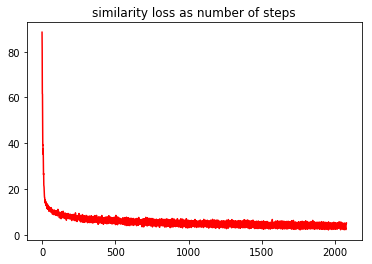

In [23]:
plot.title('similarity loss as number of steps')
plot.plot(loss_step, loss2_val, 'r')
plot.show()

# Evaluation fo similarity check

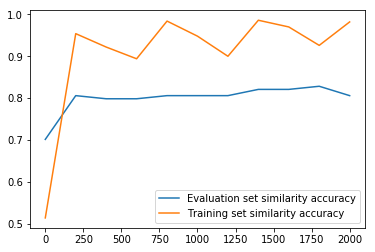

In [24]:
plot.plot(evaluation_step, sim_val, label='Evaluation set similarity accuracy')
plot.plot(evaluation_step, sim_train, label='Training set similarity accuracy')
plot.legend()
plot.show()

In [25]:
model = CombinedClassifier(num_of_ids=num_of_ids, loss_type="Similarity", similarity_threshold=5)
model.load_weights('cpt/cpt_sim_20')
_, sim, ratio = model.test(data_dict['X_eval'], data_dict['y_eval'], similarity_test=True, thresh=best_thresh)
print("Summary for similarity threshold = 20: similarity accuracy = {}, sim diff ratio = {}".format(sim, ratio))

Summary for similarity threshold = 20: similarity accuracy = 0.8283582089552238, sim diff ratio = 0.4459783434867859


## Similarity test results summary:
### similarity threshold 5: accuracy=82.0%, sim diff ratio=0.48
### similarity threshold 10: accuracy=82.0%, sim diff ratio=0.47
### similarity threshold 20: accuracy=82.8%, sim diff ratio=0.44

### Summary: The higher the threshold set, the higher accuracy and sim diff ration.